# Exploring the Influence of Big Flood Events on Insurance Buying Behaviour in Three States

In this notebook, we will compare flood insurance policy data from three states to illustrate the impact of major flood events on insurance adoption. Two of these states have experienced flooding with extensive damage in recent years, Texas was hit particularly hard by [Hurricane Harvey](https://en.wikipedia.org/wiki/Hurricane_Harvey) in 2017 and Louisiana suffered from the [2016 Louisiana Floods](https://en.wikipedia.org/wiki/2016_Louisiana_floods). The third state was chosen for not having experienced recent major flooding (and for being conveniently small) - Montana.

The full [dataset](https://www.fema.gov/openfema-data-page/fima-nfip-redacted-policies-v1) we are working with consists of records of all NFIP (National Flood Insurance Program, run by the Federal Emergency Management Agency) flood policies that went into effect starting in 2009 and has over 60.000.000 entries and 46 columns. (To generate the state specific datafiles used in this notebook, run the state_data_generation notebook.) The information we will primarily be concerned with here are the years policies went into effect, the flood zone of the covered property, coverage amount and type and finally the year a policy was first issued (policies typically run for one year and need to be renewed then).

## Data Preparation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.preprocessing import clean_state

sns.set_context("notebook")
sns.set_style("whitegrid")
sns.set_palette("dark")
pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)

Loading the state datasets (to generate these parquet files from FimaNfipPolicies.csv, run the state_data_generation notebook).

In [3]:
tx = pd.read_parquet("../data/TXPolicies.parquet")
la = pd.read_parquet("../data/LAPolicies.parquet")
mo = pd.read_parquet("../data/MOPolicies.parquet")

Apart from dropping a few rows that seem to contain data entry errors, preprocessing adds a start year of the policy column and some columns to facilitate distinguishing mandatory from voluntary insurance policies, by separating groups of flood zones (flood insurance being mandatory in zones with designations starting with "A" or "V") and adding an indicator for the policy containing content coverage (as opposed to just building coverage), which is voluntary.

In [4]:
mo = clean_state(mo)
la = clean_state(la)
tx = clean_state(tx)

These are the added columns:

In [5]:
mo.loc[:, "start_year":].head()

,start_year,term_year,construction_year,originalNB_year,genFloodZone,pooledFloodZone,zoneStatus,contentInsurance
0,2012,2013,2009.0,2011.0,A,A,Mandatory,True
1,2020,2021,1989.0,2011.0,X,"X, B, C, D",Voluntary,True
2,2019,2020,1989.0,2011.0,X,"X, B, C, D",Voluntary,True
3,2018,2019,1989.0,2011.0,X,"X, B, C, D",Voluntary,True
4,2017,2018,1989.0,2011.0,X,"X, B, C, D",Voluntary,True


## State Comparisons: Flood Insurance Policies over Time?

In this section, we are going to look at how the amount of flood insurance sold changes after big flood events. For this we are going to compare three states: Texas, which was hit hard by Hurricane Harvey in 2017, Louisina, which suffered the Louisiana Floods in 2016 and Monatana, which was not impacted by major flooding, will act as a control.


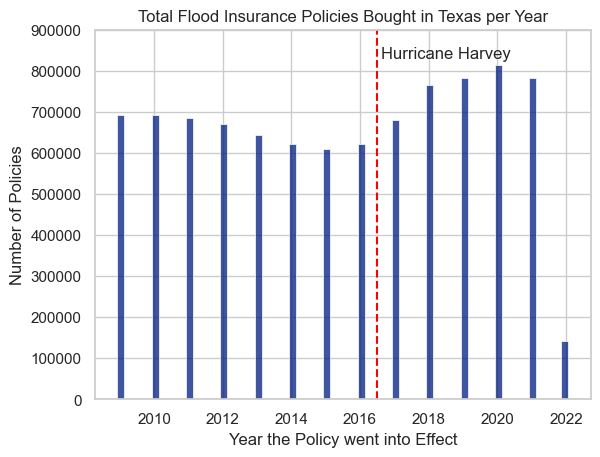

In [12]:
sns.histplot(tx.start_year, shrink=3)
plt.ylim(0, 900000)
plt.axvline(2016.5, c="r", linestyle="--")
plt.annotate("Hurricane Harvey", (2016.6, 830000))
plt.title("Total Flood Insurance Policies Bought in Texas per Year")
plt.ylabel("Number of Policies")
plt.xlabel("Year the Policy went into Effect")
plt.show()

We can see a rise in policies bought in Texas after Hurricane Harvey, while until 2015 the number of policies was trending downwards, with a very slight upward movement in 2016. The data for policies bought in 2022 is still incomplete, so the amount here is very small.


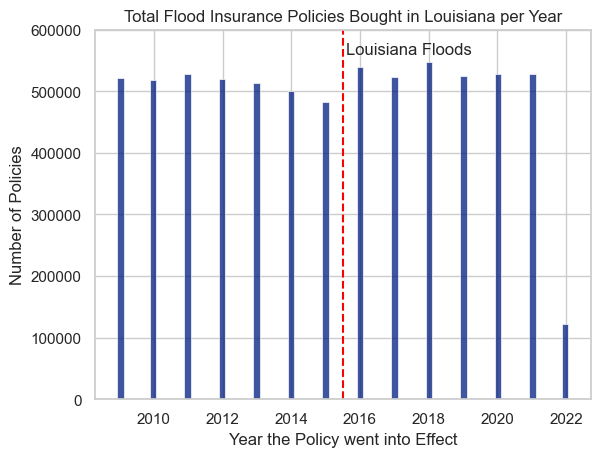

In [15]:
sns.histplot(la.start_year, shrink=3)
plt.ylim(0, 600000)
plt.axvline(2015.5, c="r", linestyle="--")
plt.annotate("Louisiana Floods", (2015.7, 560000))
plt.title("Total Flood Insurance Policies Bought in Louisiana per Year")
plt.ylabel("Number of Policies")
plt.xlabel("Year the Policy went into Effect")
plt.show()

In Louisina we see a similar earlier downward trend, with a less pronounced rise after the Louisiana Floods. The change here will become clearer, when we distinguish between voluntary and mandatory flood insurance policies, but first, to Montana:

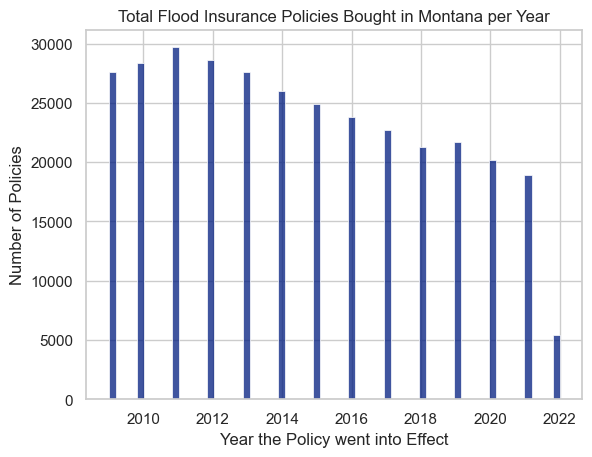

In [16]:
sns.histplot(mo.start_year)
plt.title("Total Flood Insurance Policies Bought in Montana per Year")
plt.ylabel("Number of Policies")
plt.xlabel("Year the Policy went into Effect")
plt.show()

Flood insurance in Montana is trending downwards from 2011 on. Montana doesn't like flood insurance.

We will now distinguish between mandatory and voluntary insurance policies, since mandatory ones tell us about regulatory decisions as opposed to individual insurance buying decisions. This distinction can be brought out in two ways. First, by looking at the flood zone designation of the building. Inusurance on the building is mandatory in designated areas of high flood risk, about 55% of insurance policies in our dataset are mandatory in this sense. However, even those policies can contain voluntary elements, in that insurance on the building is mandatory, but insurance on the contents of the building is not. In this sense, only about 24% of policies are (fully) mandatory. 

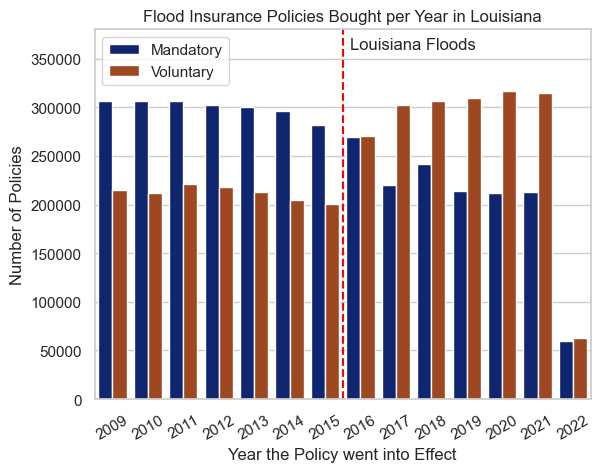

In [22]:
sns.countplot(x=la.start_year, hue=la.zoneStatus)
plt.ylim(0, 380000)
plt.axvline(6.5, c="r", linestyle="--")
plt.annotate("Louisiana Floods", (6.7, 360000))
plt.legend(loc="upper left")
plt.ylabel("Number of Policies")
plt.xticks(rotation=30)
plt.xlabel("Year the Policy went into Effect")
plt.title("Flood Insurance Policies Bought per Year in Louisiana")
plt.show()

Mandatory zone insurance numbers were slowly declining until 2016, then drop off in 2017, staying relatively steady afterwards. Voluntary zone policies exhibit almost the opposite pattern with slightly shifted timing: relatively stable until 2015, then a large jump upwards, with a slower increase after (which looks to have stalled out in 2020). Mandatory policies used to be more numerous, but are now the rarer kind. There are several dynamics at play here.

Most interestingly for our purposes, if not entirely surprisingly, big flood events seem to motivate people to buy flood insurance. A caveat about the seemingly impressive size of the effect (which we will not try to quantify, due to these complicating factors) need to be kept in mind. Some policies could get shifted from mandatory zones to voluntary zones by improvements to flood safety, e.g. construction of dams and levees. After a big flood is certainly a good time to build such. At an extreme, this could account for the full increase in voluntary insurance between 2016 and 2018, but not in any of the other years. The big increase in voluntary policies predates the largest decline in mandatory ones. A second complicating factor is that receiving FEMA emergency funds after a flood can make acquiring flood insurance mandatory, no matter the zone. To ensure that this is not all that is going on, we will next look at voluntary insurance in the second sense, i.e. contents insurance as opposed to pure building coverage, to see whether the rise is also present there.   

The slow decline in mandatory policies (which is much steeper in Montana, as we will see) is probably an effect of the enforcement mechanism: mortgage providers are required to demand flood insurance from their clients for houses in the specified flood zones. That means that buildings can 'age out' of having to be insured when their mortgage is payed off. Combined with some reluctance to build or buy in dangerous flood zones (whether due to the flood risk itself or the insurance requirement) this would lead to a steady decline in insured properties in such zones, *provided the insured does not keep their policy anyway*. More reluctance to give up flood insurance when a mortgage is paid off after the experience of a recent flood may then account for the relative stability in recent years.

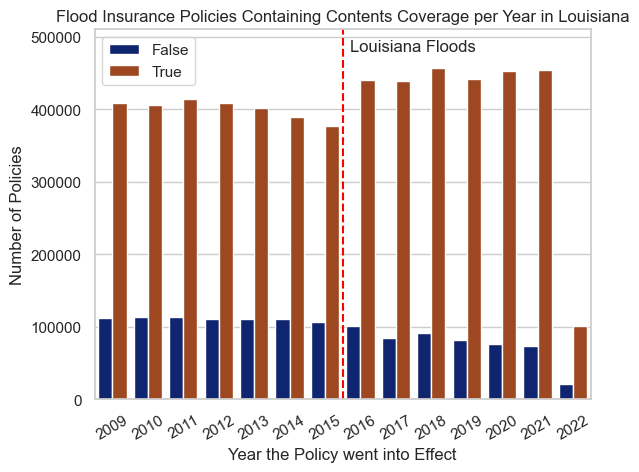

In [27]:
sns.countplot(x=la.start_year, hue=la.contentInsurance)
plt.ylim(0, 510000)
plt.axvline(6.5, c="r", linestyle="--")
plt.annotate("Louisiana Floods", (6.7, 480000))
plt.legend(loc="upper left")
plt.ylabel("Number of Policies")
plt.xticks(rotation=30)
plt.xlabel("Year the Policy went into Effect")
plt.title("Flood Insurance Policies Containing Contents Coverage per Year in Louisiana")
plt.show()

The rise in contents coverage is less pronounced, but certainly there, starting from an already high level of people adding contents coverage to their insurance.

Interestingly, we see a slow decline between 2011 and 2015, just like with insurance policies in mandatory zones. This could suggest that the insurance for these buildings was not actually cancelled as soon as mortgages were paid off, but instead people just moved out. However, this is quite speculative. 

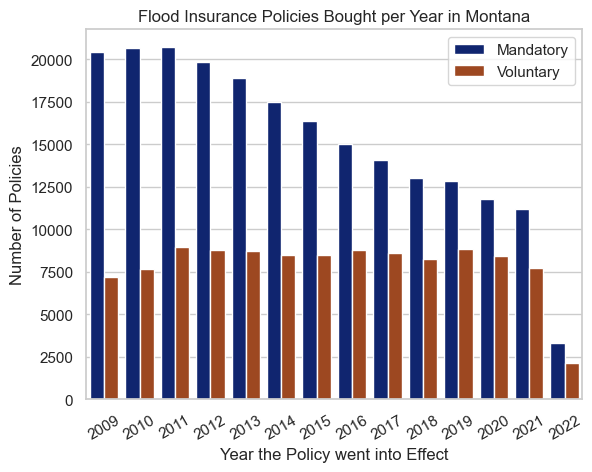

In [40]:
sns.countplot(x=mo.start_year, hue=mo.zoneStatus)
plt.ylabel("Number of Policies")
plt.xticks(rotation=30)
plt.xlabel("Year the Policy went into Effect")
plt.title("Flood Insurance Policies Bought per Year in Montana")
plt.legend()
plt.show()

In Montana, voluntary insurance has been fairly stable, while mandatory insurance has been on a steady decline starting around 2012. This suggests that buildings are indeed 'aging out' of mandatory insurance (or possibly out of being inhabited in the first place). Montana doesn't like flood insurance.

Mandatory insurance is more common here than voluntary, we will see that in Texas the opposite is the case. First a quick look at contents insurance in Montana:

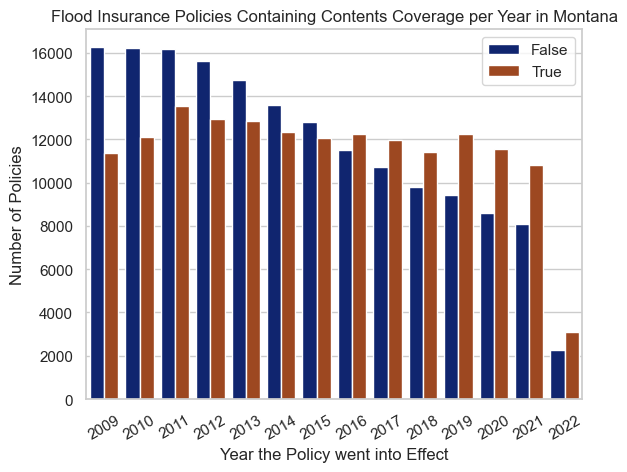

In [30]:
sns.countplot(x=mo.start_year, hue=mo.contentInsurance)
plt.legend(loc="upper right")
plt.ylabel("Number of Policies")
plt.xticks(rotation=30)
plt.xlabel("Year the Policy went into Effect")
plt.title("Flood Insurance Policies Containing Contents Coverage per Year in Montana")
plt.show()

Here insurance without contents coverage follows a very similar pattern of decline as mandatory zone insurance, so these policy holders in Montana, indeed, look to just be ditching their insurance, as soon as they are not required to hold it anymore. It's them who don't like flood insurance. 

Policies including contents insurance behave similarly to voluntary zone policies in being relatively stable with a small rise up to 2011 and a small decline after 2019, albeit at a much higer level. Contents insurance including policies overtake those without in 2016 as the more common form of insurance. Not everyone in Montana doesn't like flood insurance.

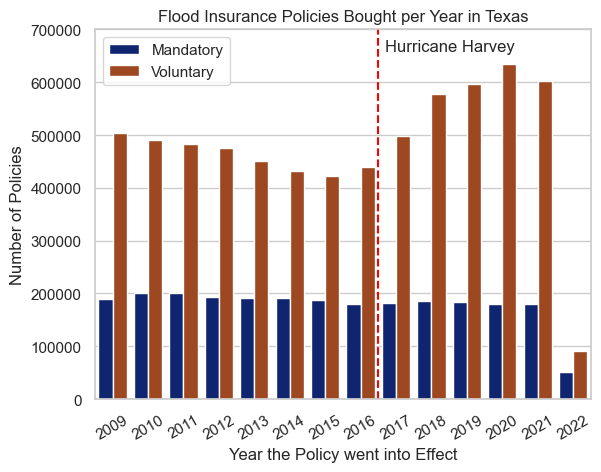

In [24]:
sns.countplot(x=tx.start_year, hue=tx.zoneStatus, hue_order=["Mandatory", "Voluntary"])
plt.ylim(0, 700000)
plt.axvline(7.5, c="r", linestyle="--")
plt.annotate("Hurricane Harvey", (7.7, 660000))
plt.legend(loc="upper left")
plt.ylabel("Number of Policies")
plt.xticks(rotation=30)
plt.xlabel("Year the Policy went into Effect")
plt.title("Flood Insurance Policies Bought per Year in Texas")
plt.show()

Voluntary zone insurance was the more common form of insurance in Texas in the first year of our dataset already. Mandatory flood insurance policy numbers are quite stable over time, while voluntary policies were slowly declining from 2009 to 2015, got a small bump in 2016 and then, in the year of hurricane Harvey started a much faster upwards trend, reaching its high point in 2020. Contents insurance paints a similar picture:

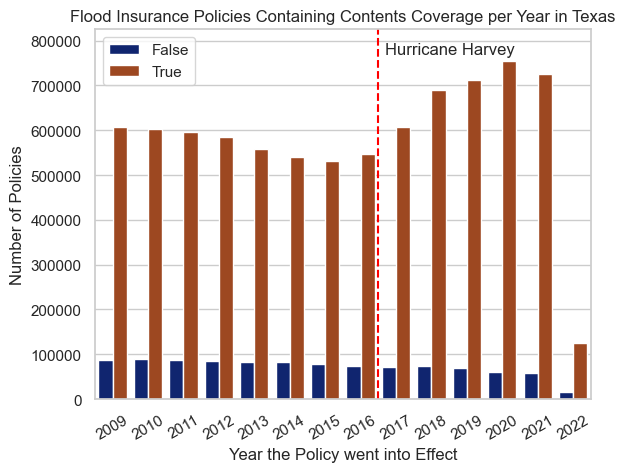

In [20]:
sns.countplot(x=tx.start_year, hue=tx.contentInsurance)
plt.ylim(0, 825000)
plt.axvline(7.5, c="r", linestyle="--")
plt.annotate("Hurricane Harvey", (7.7, 770000))
plt.legend(loc="upper left")
plt.ylabel("Number of Policies")
plt.xticks(rotation=30)
plt.xlabel("Year the Policy went into Effect")
plt.title("Flood Insurance Policies Containing Contents Coverage per Year in Texas")
plt.show()

The development in the amount of policies is pretty much the same, what is striking is how rare flood insurance without any voluntary element is in Texas. Even in the worst year for contents coverage (2015) policies including it outnumber policies that do not by almost seven to one.

In [ ]:
tx_med_by_year = tx.groupby("start_year").median()
la_med_by_year = la.groupby("start_year").median()
mo_med_by_year = mo.groupby("start_year").median()

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plt.suptitle("Median Total Contents and Building Coverage by Year")
ax[0].set_title("Contents Coverage")
ax[0].plot(tx.groupby("start_year").median().totalContentsInsuranceCoverage)
ax[0].plot(la.groupby("start_year").median().totalContentsInsuranceCoverage)
ax[0].plot(mo.groupby("start_year").median().totalContentsInsuranceCoverage)
ax[0].legend(["Texas", "Louisiana", "Montana"])
ax[1].set_title("Building Coverage")
ax[1].plot(tx.groupby("start_year").median().totalBuildingInsuranceCoverage)
ax[1].plot(la.groupby("start_year").median().totalBuildingInsuranceCoverage)
ax[1].plot(mo.groupby("start_year").median().totalBuildingInsuranceCoverage)
ax[1].legend(["Texas", "Louisiana", "Montana"])
plt.show()

The median insurance coverage for contents and buildings shows a rise in demand for flood insurance after catastrophic events as well. The median is particularly illustrative in this case, because Nfip policies have an upper limit for each kind of coverage, 100.000$ for contents and 250.000$ for buildings (for single family houses, which are by far the most common kind of building in the dataset). We can see here, that these are both maxed out for the median policy in Texas, contents coverage since 2017, the year of Hurricane Harvey, but building coverage since 2015, so it did not have a chance to go up in 2017. Louisiana maxed out building coverage only in 2019, but this rise starts the year of the Louisiana floods. Contents coverage in Louisina is now at a median of 80.000$, rising there from 45.000$ between 2015 and 2019. Both kinds of coverage are consistently much lower and rise more gradually in Montana than in the two other states. Until 2015 the median contents coverage in Montana is actually 0. Montana doesn't like flood insurance.     

## Bonus: Hurricane Katrina in the Data

The dataset only includes policies in effect starting in 2009, so we are not able to take a close and careful look at the effects of hurricane Katrina, tied with Harvey as costliest Hurricane, on flood insurance. We can still get a glimpse at it, since we do have a date for when a policy was originally bought, even if it renews every year and its starting date is 2009 at the earlist.

Since that means we can only see how many insurance policies were first bought in the aftermath of Katrina *that are still in effect in 2009* the following is by no means a complete picture. Still, the spikes of new insurance policies in the year after Katrina (which was in August 2005), are impressive in both Louisiana and Texas, which were both impacted:

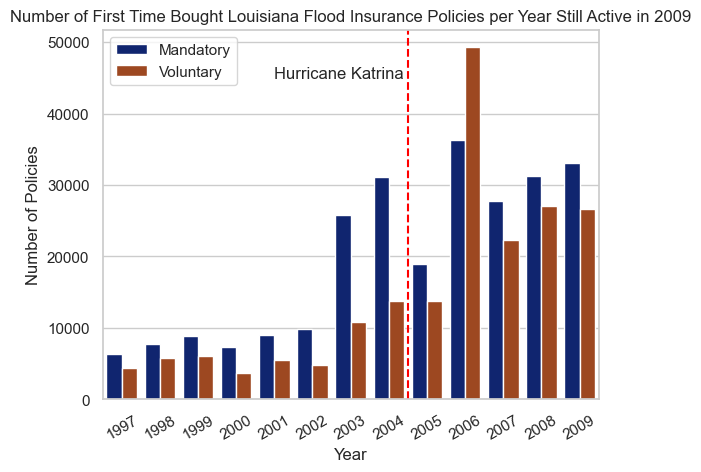

In [42]:
sns.countplot(x=la[(la.start_year == 2009) & (la.originalNB_year < 2010) & (la.originalNB_year > 1996)].originalNB_year.astype("int16"), hue=la.zoneStatus)
plt.axvline(7.5, c="r", linestyle="--")
plt.annotate("Hurricane Katrina", (4, 45000))
plt.xticks(rotation=30)
plt.title("Number of First Time Bought Louisiana Flood Insurance Policies per Year Still Active in 2009")
plt.xlabel("Year")
plt.ylabel("Number of Policies")
plt.legend()
plt.show()

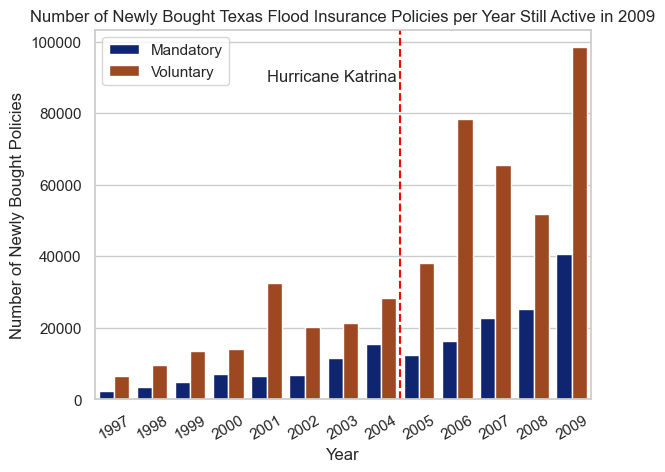

In [41]:
sns.countplot(x=tx[(tx.start_year == 2009) & (tx.originalNB_year < 2010) & (tx.originalNB_year > 1996)].originalNB_year.astype("int16"), hue=tx.zoneStatus, hue_order=["Mandatory", "Voluntary"])
plt.axvline(7.5, c="r", linestyle="--")
plt.annotate("Hurricane Katrina", (4, 89000))
plt.xticks(rotation=30)
plt.title("Number of First Time Bought Texas Flood Insurance Policies per Year Still Active in 2009")
plt.xlabel("Year")
plt.ylabel("Number of Policies")
plt.legend()
plt.show()

But guess who doesn't care about Hurricane Katrina:

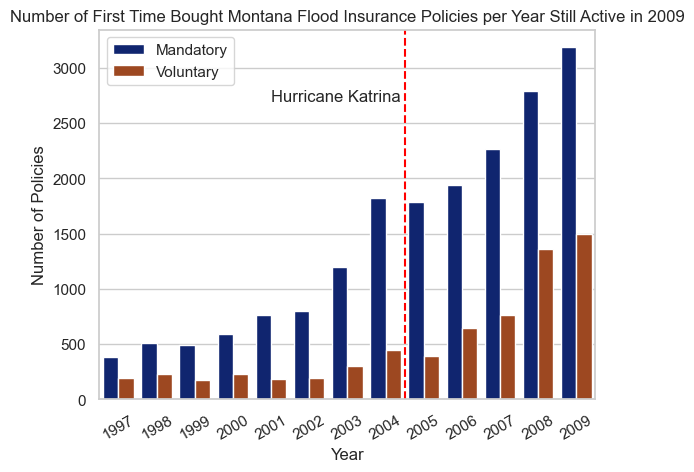

In [46]:
sns.countplot(x=mo[(mo.start_year == 2009) & (mo.originalNB_year < 2010) & (mo.originalNB_year > 1996)].originalNB_year.astype("int16"), hue=mo.zoneStatus)
plt.axvline(7.5, c="r", linestyle="--")
plt.annotate("Hurricane Katrina", (4, 2700))
plt.xticks(rotation=30)
plt.title("Number of First Time Bought Montana Flood Insurance Policies per Year Still Active in 2009")
plt.xlabel("Year")
plt.ylabel("Number of Policies")
plt.legend()
plt.show()

Of course it is Montana, which dislikes flood insurance **that** much.